<a href="https://colab.research.google.com/github/mikethisyamondol/digit_recognizer/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer: MNIST Dataset
<br>
Mike Thisyamondol

### Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from IPython import display
import pickle
import datetime
import os
from IPython.display import clear_output

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

clear_output()

In [3]:
with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [4]:
! pip install kaggle

clear_output()

In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download digit-recognizer
clear_output()

In [9]:
df_train = pd.read_csv('./train.csv.zip')
df_test = pd.read_csv('./test.csv.zip')

### Quick EDA & Tranformations

In [10]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Check nulls
df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [12]:
# Check nulls
df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [13]:
# Check label class distribution
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [14]:
df_train['pixel34'].value_counts()

0      41995
85         1
2          1
157        1
132        1
67         1
Name: pixel34, dtype: int64

In [15]:
x = df_train.drop(['label'], axis = 1)
y = df_train['label']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [17]:
# Normalize image data based on 255 pixel values
x /= 255
x_train /= 255
x_test /= 255
df_test /= 255

### Modeling/Experiment

In [18]:
def cross_val(model, x_train, y_train):
  start = datetime.datetime.now()
  kf = StratifiedKFold(n_splits=7, shuffle=True)
  c = cross_val_score(model, x_train, y_train, cv=kf)
  end = datetime.datetime.now()
  print(f'Cross Validation Score: {c.mean().round(3)} ± {c.std().round(3)} // Time: {end-start}')


In [19]:
def model_fit(model, x_train, y_train, x_test, y_test):
  start = datetime.datetime.now()
  model.fit(x_train, y_train)
  end = datetime.datetime.now()
  print(f'Oob Score: {model.oob_score_}')
  print(f'Test Score: {model.score(x_test, y_test)}')
  print(f'Training Time: {end-start}')
  return model

#### Random Forest

In [20]:
rf1 = RandomForestClassifier(oob_score=True, n_estimators=200)
cross_val(rf1, x_train, y_train)

Cross Validation Score: 0.964 ± 0.002 // Time: 0:05:47.408259


In [21]:
rf1 = model_fit(rf1, x_train, y_train, x_test, y_test)

Oob Score: 0.9638690476190476
Test Score: 0.9626190476190476
Training Time: 0:00:57.893606


In [22]:
# Training Preds
rf1_preds_train = rf1.predict(x_test)
rf1_preds_train_df = pd.DataFrame(rf1_preds_train, columns=['preds'])
rf1_preds_train_df["target"] = list(y_test)

In [23]:
target_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(rf1_preds_train_df['target'], rf1_preds_train_df['preds'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       786
           1       0.99      0.98      0.99       992
           2       0.94      0.96      0.95       830
           3       0.95      0.94      0.94       876
           4       0.96      0.96      0.96       769
           5       0.98      0.96      0.97       771
           6       0.96      0.98      0.97       830
           7       0.97      0.97      0.97       901
           8       0.95      0.94      0.94       812
           9       0.94      0.95      0.95       833

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [24]:
# # Kaggle Prediction
# rf1_preds = rf1.predict(df_test)
# rf1_preds = pd.Series(rf1_preds, name="Label")

# submission1 = pd.concat([pd.Series(range(len(df_test)), name = "ImageId"), rf1_preds], axis = 1)
# submission1['ImageId'] = submission1['ImageId']+1
# submission1.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission1.csv', index=False)

#### Random Forest with PCA

In [25]:
pca = PCA()
pca = pca.fit(x_train)

In [26]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
n = np.argmax(cum_var_exp >= 0.95) + 1

Text(0.5, 1.0, 'Component vs Cumulative variance explained\n')

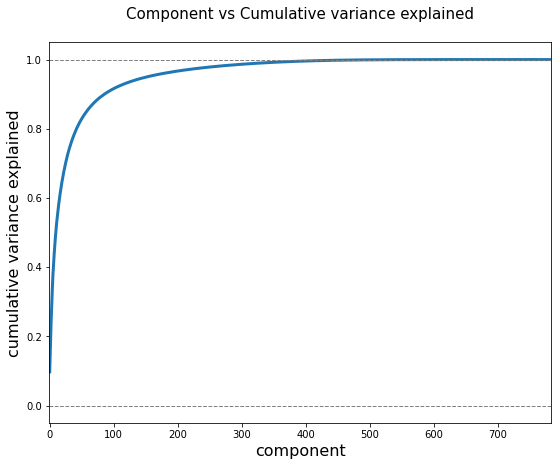

In [27]:
plt.figure(figsize=(9,7))

component_number = range(len(cum_var_exp))
plt.plot(component_number, cum_var_exp, lw=3)

plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([-1,len(cum_var_exp)])
ax.set_ylim([-0.05,1.05])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)
ax.set_title('Component vs Cumulative variance explained\n', fontsize=15)

In [28]:
pca = PCA(n_components = n)
z_train = pca.fit_transform(x_train)
z_test = pca.transform(x_test)

In [29]:
z_train.shape

(33600, 153)

In [30]:
rf2 = RandomForestClassifier(oob_score=True, n_estimators=200)
cross_val(rf2, z_train, y_train)

Cross Validation Score: 0.942 ± 0.001 // Time: 0:11:39.494526


In [31]:
rf2 = model_fit(rf2, z_train, y_train, z_test, y_test)

Oob Score: 0.9391369047619048
Test Score: 0.9451190476190476
Training Time: 0:01:54.838789


It's not surprising that the model using PCA did not perform as well, given there might be some pixel data that doesn't make it into the model that might make let's say a 4 and a 9 indistinguishable. The surprising thing is that the model using PCA took a longer time to fit than the first model without PCA. 

In [32]:
# Training Preds
rf2_preds_train = rf2.predict(z_test)
rf2_preds_train_df = pd.DataFrame(rf2_preds_train, columns=['preds'])
rf2_preds_train_df["target"] = list(y_test)

In [33]:
print(classification_report(rf2_preds_train_df['target'], rf2_preds_train_df['preds'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       786
           1       0.98      0.98      0.98       992
           2       0.92      0.94      0.93       830
           3       0.91      0.92      0.92       876
           4       0.93      0.93      0.93       769
           5       0.96      0.94      0.95       771
           6       0.95      0.98      0.96       830
           7       0.97      0.95      0.96       901
           8       0.93      0.90      0.91       812
           9       0.92      0.93      0.92       833

    accuracy                           0.95      8400
   macro avg       0.94      0.94      0.94      8400
weighted avg       0.95      0.95      0.95      8400



In [34]:
# # Kaggle Prediction
# test_reduced = pca.transform(df_test)
# rf2_preds = rf2.predict(test_reduced)
# rf2_preds = pd.Series(rf2_preds, name="Label")

# submission2 = pd.concat([pd.Series(range(len(df_test)), name = "ImageId"), rf2_preds], axis = 1)
# submission2['ImageId'] = submission2['ImageId']+1
# submission2.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission2.csv', index=False)

#### K-Means Clustering

In [62]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label


# Mapping predictions to original labels
def get_labels(model, refernce_labels):
  
    # temp_labels = np.random.rand(len(clusters))
    # for i in range(len(clusters)):
    #     temp_labels[i] = reference_labels[clusters[i]]
    # return temp_labels

    number_labels = np.random.rand(len(model.labels_))
    for i in range(len(model.labels_)):
      number_labels[i] = reference_labels[model.labels_[i]]
    
    return number_labels

In [63]:
# Using 10 Clusters
n = len(y.unique())
km = KMeans(n_clusters=n)
km.fit(x)
clusters = km.predict(x)

In [64]:
reference_labels = get_reference_dict(clusters, y)
predicted_labels = get_labels(km,reference_labels)
print(reference_labels)
print(accuracy_score(predicted_labels, y))

{0: 3, 1: 4, 2: 1, 3: 7, 4: 2, 5: 6, 6: 1, 7: 6, 8: 8, 9: 0}
0.5839285714285715


In [65]:
print(f'Inertia: {km.inertia_}')

Inertia: 1648391.2374898389


In [66]:
cm = confusion_matrix(y, predicted_labels)
cm_df = pd.DataFrame(cm, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
                     index = ["Actual 0", "Actual 1", "Actual 2", "Actual3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,3027,2,4,188,24,0,853,2,32,0
Actual 1,0,4652,3,5,5,0,8,5,6,0
Actual 2,30,518,2893,193,135,0,231,49,128,0
Actual3,17,308,125,2757,122,0,327,24,671,0
Actual 4,6,260,20,0,2265,0,246,1267,8,0
Actual 5,38,310,3,1326,243,0,1086,153,636,0
Actual 6,54,147,18,21,44,0,3844,3,6,0
Actual 7,12,409,31,5,1318,0,10,2603,13,0
Actual 8,23,399,25,722,115,0,182,113,2484,0
Actual 9,33,227,6,52,2127,0,32,1658,53,0


In [40]:
# km_test_preds = km.predict(df_test)
# test_predicted_labels = get_labels(km, reference_labels)
# test_predicted_labels = np.array([int(x) for x in test_predicted_labels])

# km_preds = pd.Series(test_predicted_labels, name="Label")
# submission3 = pd.concat([pd.Series(range(len(df_test)), name = "ImageId"), km_preds], axis = 1)
# submission3['ImageId'] = submission3['ImageId']+1
# submission3.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission3.csv', index=False)

The k-means clustering model did not perform very well with an accuracy of ~60%. I'm curious if increasing the number of clusters would increase the accuracy score, the reason being a given number can be written in different ways, some of which have similarities to other numbers. It would be interesting to see how much the model improves with a higher number of clusters.

Next iteration:

In [41]:
# # Using 30 Clusters
# km2 = MiniBatchKMeans(n_clusters=n*30)
# km2.fit(x)
# clusters2 = km2.predict(x)

In [67]:
# reference_labels2 = get_reference_dict(clusters2, y)
# # predicted_labels2 = get_labels(clusters2, reference_labels)

# number_labels = np.random.rand(len(km2.labels_))
# for i in range(len(km2.labels_)):
#   number_labels[i] = reference_labels2[km2.labels_[i]]
# print(reference_labels2)
# print(accuracy_score(number_labels, y))

In [54]:
# reference_labels2 = get_reference_dict(clusters2, y)
# predicted_labels2 = get_labels(km2, reference_labels2)
# print(reference_labels2)
# print(accuracy_score(predicted_labels2, y))

In [68]:
# print(f'Inertia: {km2.inertia_}')

In [69]:
# cm2 = confusion_matrix(y, number_labels)
# cm_df2 = pd.DataFrame(cm2, columns = ["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"], 
#                      index = ["Actual 0", "Actual 1", "Actual 2", "Actual3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"])
# cm_df2

In [61]:
# km_test_preds2 = km2.predict(df_test)
# test_predicted_labels2 = np.random.rand(len(km2.labels_))
# for i in range(len(km2.labels_)):
#   test_predicted_labels2[i] = reference_labels2[km2.labels_[i]]
# test_predicted_labels2 = np.array([int(x) for x in test_predicted_labels2])

# km_preds2 = pd.Series(test_predicted_labels2, name="Label")
# submission4 = pd.concat([pd.Series(range(len(df_test)), name = "ImageId"), km_preds2], axis = 1)
# submission4['ImageId'] = submission4['ImageId']+1
# submission4.to_csv('./drive/MyDrive/Colab Notebooks/MSDS422/digit_submission4.csv', index=False)